In [1]:
import os

import torch
import numpy as np
import pandas as pd

from retinanet import model, val
from PIL import Image
import PIL
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline

In [2]:
tag = 'debug'
split_name = 'voc-1'
depth = 50
date_time = "20190516_175626"

max_detections = 4
num_classes = 2

img_root_path = "/home/voyager/data/root"
img_path = os.path.join(img_root_path, "voc/JPEGImages")

model_name = "151_0.3333"
score_threshold = 0.5
scale = 1.2

eval_result_path = './result/{}_{}_{}_{}'.format(
    tag,
    depth,
    split_name,
    date_time
)
manual_annotation = "bbox_score.csv"
detection = "{}_{}_{}_{}.csv".format(
            model_name,
            num_classes,
            score_threshold,
            max_detections
        )

选择加载的数据，手工标注或者是预测出来的标注。最终切出来的图片将储存到对应的result_path。

In [4]:
# get the result from manual annotation
img_pd = pd.read_csv(os.path.join(img_root_path, manual_annotation))
result_path = os.path.join(img_root_path, "manual_crop")

In [5]:
# get the result path from detection 
img_pd = pd.read_csv(os.path.join(eval_result_path, detection))
result_path = os.path.join(img_root_path, "detection_crop")

选择一部分数据观察标注效果

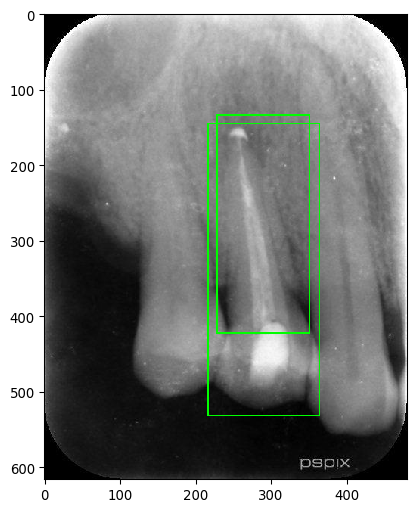

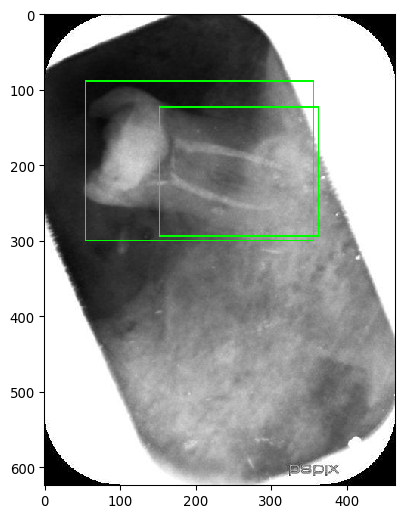

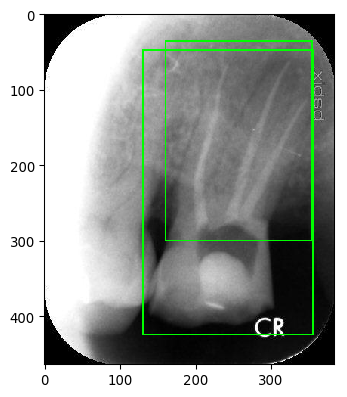

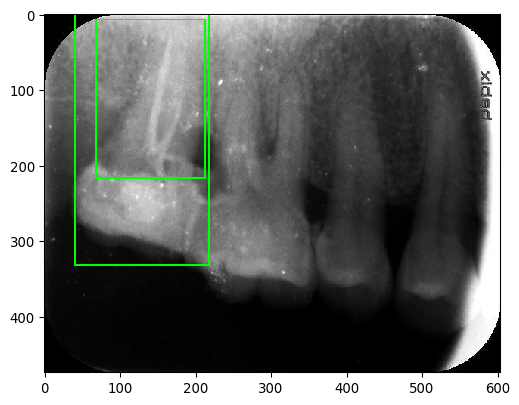

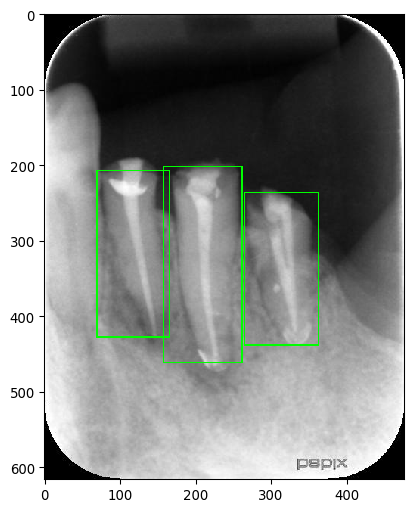

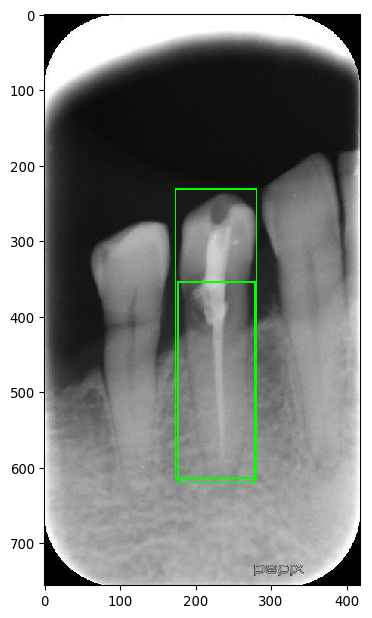

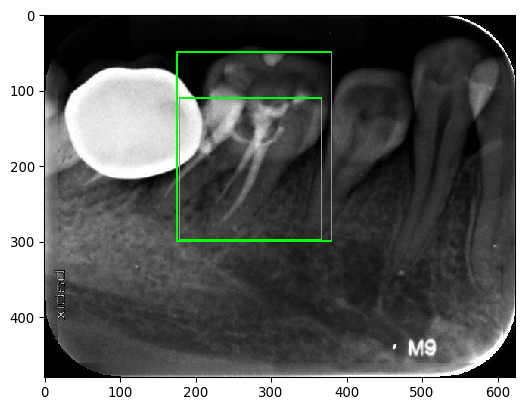

In [6]:
def draw_box(img_pd, img_path=None):
    # get the img dataframe and origin image path, and draw boxes on images
    name_series = img_pd.drop_duplicates(subset='id', inplace=False)['id']
    
    for image_name in name_series:
        img_some = img_pd[img_pd['id'] == image_name]
        # only get class 0
        # img_some = img_some[img_some['class'] == 0]
        
        img = Image.open(os.path.join(img_path, image_name + ".jpg"))
        np_img = np.asarray(img)
        # draw all box on the selected image
        for index in range(img_some.shape[0]):
            img_detect = img_some.iloc[index]
        
            img_id = img_detect['id']
            label = img_detect['class']
            x1 = img_detect['x1']
            y1 = img_detect['y1']
            x2 = img_detect['x2']
            y2 = img_detect['y2']
            bbs = []
            bbs.append(BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2))
            bbs_on_img = BoundingBoxesOnImage(bbs, shape=np_img.shape)
            np_img = bbs_on_img.draw_on_image(np_img, size=2, color=[0, 255, 0])
        
        ia.imshow(np_img)

draw_box(img_pd[0:15], img_path=img_path)

In [7]:
def save_crop_box(img_pd, img_path=None, result_path=None, scale=1):
    # crop box on images which under img_path, and save under result_path, following img_pd's guide.
    #  Scale control the size ratio between new and old images.
    for index in range(img_pd.shape[0]):
        img = img_pd.iloc[index]
        
        uid = img['id']
        serial = img['serial']
        x1 = img['x1']
        y1 = img['y1']
        x2 = img['x2']
        y2 = img['y2']
        deltaw = (x2 - x1) * (scale - 1) / 2
        x1 -= deltaw
        x2 += deltaw
        deltah = (y2 - y1) * (scale - 1) / 2
        y1 -= deltah
        y2 += deltah
        
        img = Image.open(os.path.join(img_path, uid + ".jpg"))
        
        # box – The crop rectangle, as a (left, upper, right, lower)-tuple
        box = (x1, y1, x2, y2)
        file_name = os.path.join(result_path, '{}_{}.jpg'.format(uid, serial))
        
        box = img.crop(box).save(file_name)
        
        
save_crop_box(img_pd[:], img_path=img_path, result_path=result_path, scale=scale)